# Major Leagues
- EECS 731 Project 5
- Author: Lazarus
- ID : 3028051
 
 
## Problem Statement
### Shipping and delivering to a place near you
1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the product demand data set from
https://www.kaggle.com/felixzhao/productdemandforecasting
3. Load the data set into panda data frames
4. Formulate one or two ideas on how feature engineering would help the data set to establish additional value using exploratory data analysis
5. Build one or more forecasting models to determine the demand for a particular product using the other columns as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub

## What we want to do?
- Build one or more forecasting models to determine the demand for a particular product using the other columns as features


## Step 1: Prepare Environment and import Data
- Let's import pandas, numpy and pyplot libraries

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [294]:
product_data= pd.read_csv("../data/Historical_Product_Demand.csv")
product_data.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


## Step 2: Data analysis and Feature Engineering 

- Lets look at how much data we are dealing with 

In [295]:
product_data.shape

(1048575, 5)

- Let's plot warehouses vs count of them

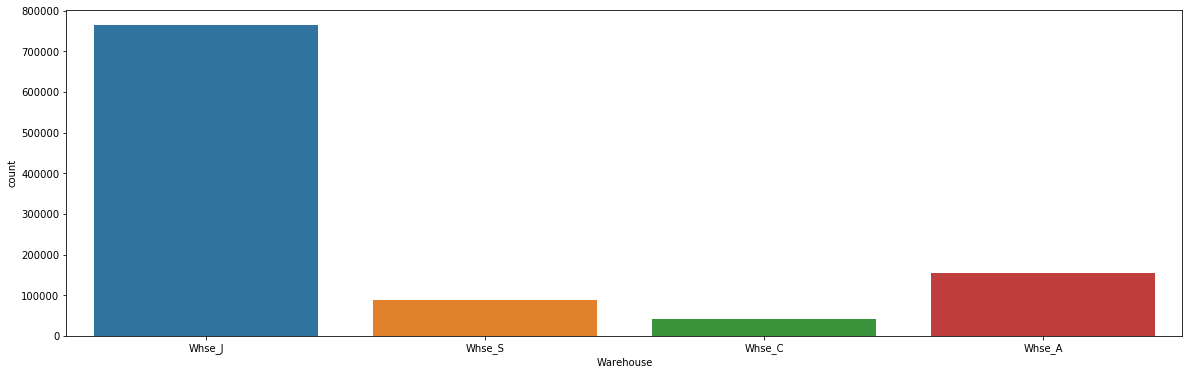

In [296]:
sns.countplot(x="Warehouse", data= product_data)

### Treating Missing values

In [297]:
print("::::::::before:::::::::::")
print(product_data.isnull().sum())
product_data=product_data.dropna()
print("::::::::after::::::::::::")
print(product_data.isnull().sum())

::::::::before:::::::::::
Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
::::::::after::::::::::::
Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64


### Let's use describe function to find out most repeated product in dataset

In [298]:
product_data.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1037336,1037336,1037336,1037336,1037336
unique,2160,4,33,1729,3749
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,470266,2075,112263


- We see that Product_1359 is at the top so let's use this particular product for our forecasting Model
- Let's create a new dataset which has only data related to product_1359

In [299]:
df = product_data.loc[product_data['Product_Code'] == 'Product_1359']
df = df.drop(columns=['Product_Code', 'Warehouse', 'Product_Category'])
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date'])
df = df.reset_index(drop=True)
df.head()

,Date,Order_Demand
0,2012-01-05,1000
1,2012-01-05,5000
2,2012-01-05,2000
3,2012-01-05,10000
4,2012-01-05,5000


- As we can see with same date there are multiple samples so lets combine such samples by adding demand values

In [300]:
demands = []

for index, row in df.iterrows():
    demands.append(int(row['Order_Demand'].strip('()')))
    
df['Demand'] = demands
df = df.groupby('Date').agg({'Demand': 'sum'})
df.reset_index(inplace=True)
df.head()

,Date,Demand
0,2012-01-05,702000
1,2012-01-06,676000
2,2012-01-10,783000
3,2012-01-11,200000
4,2012-01-12,284000


### Let's plot the demand of product_1359

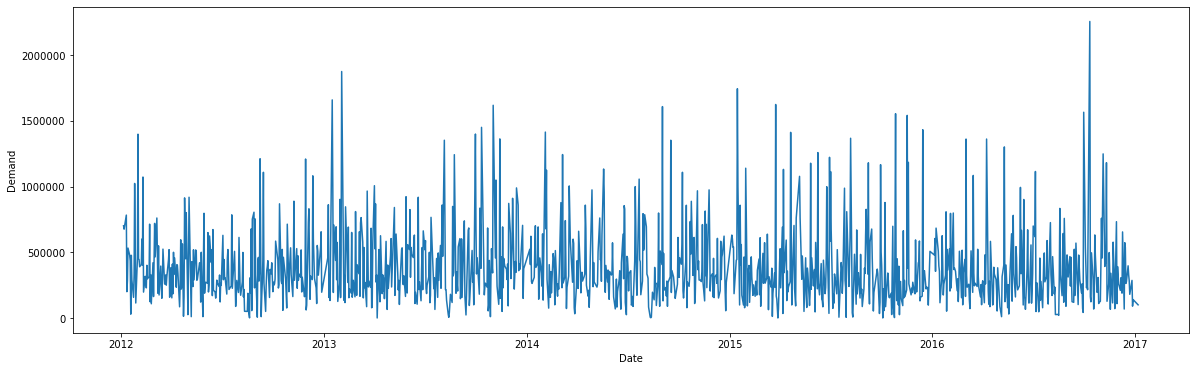

In [263]:
f, ax = plt.subplots(figsize=(20,6))
sns.lineplot(x= "Date", y="Demand", data= df)

- Now let's split date attribute to day, month and year

In [301]:
df["Date"]=df['Date'].astype(str)
asl=df['Date'].str.split('-',n=-1,expand=True) 

df['year']=asl[0]
df['month']=asl[1]
df['day']=asl[2]
# df=df.drop(['Date'],axis=1)
df['year']=df['year'].astype(int)
df['month']=df['month'].astype(int)
df['day']=df['day'].astype(int)

df=df.set_index('Date')
df.head(5)

,Demand,year,month,day
Date,,,,
2012-01-05,702000,2012,1,5
2012-01-06,676000,2012,1,6
2012-01-10,783000,2012,1,10
2012-01-11,200000,2012,1,11
2012-01-12,284000,2012,1,12


### Now we have our data to train lets split it such that we use 20% of data for testing 

In [302]:
from sklearn.model_selection import train_test_split
x = df.drop(['Demand'], axis=1)
y = df["Demand"]
xtr, xval, ytr, yval = train_test_split(x, y, test_size=.2, shuffle=False)

## Forecasting Models

### Linear Regression model

In [270]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

reg= LinearRegression().fit(xtr,ytr)
print("Training R2 score",reg.score(xtr,ytr))
print("Testing R2 score",reg.score(xval,yval))
df["reg"]=reg.predict(x)
df.head(5)


Training R2 score 0.00798308424338956
Testing R2 score -0.001335919802511798


,Demand,year,month,day,reg,xgboost
Date,,,,,,
2012-01-05,702000,2012,1,5,435900.868152,718106.437500
2012-01-06,676000,2012,1,6,433042.279201,668315.250000
2012-01-10,783000,2012,1,10,421607.923400,739038.187500
2012-01-11,200000,2012,1,11,418749.334449,225893.921875
2012-01-12,284000,2012,1,12,415890.745499,281980.906250


- we can not make much from this, lets visualize predictions to understand better how Linear Regression model performed

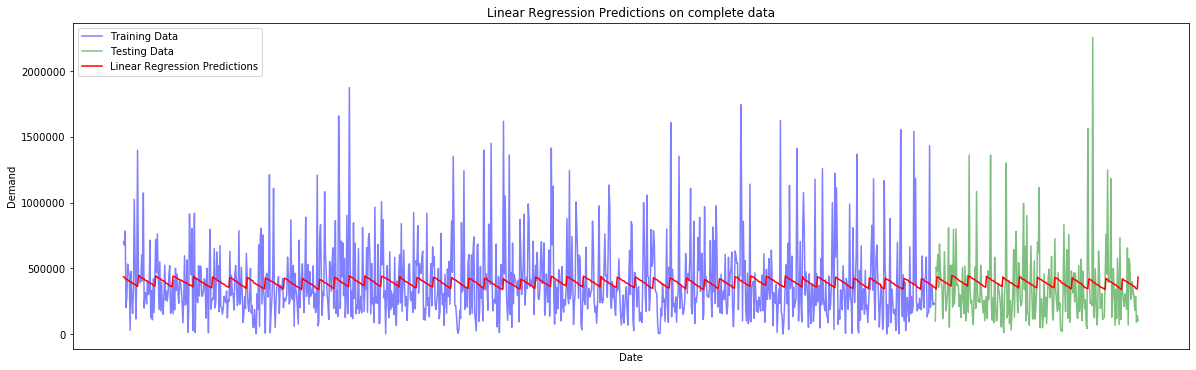

In [288]:
plt.rcParams['figure.figsize'] = [20, 6]
plt.plot(xtr.index.values, ytr, color='blue', label='Training Data', alpha=0.5)
plt.plot(xval.index.values, yval, color='green', label='Testing Data', alpha=0.5)
plt.plot(df.index.values, df['reg'], color='red', label='Linear Regression Predictions')
plt.legend(loc='best')
plt.ylabel("Demand")
plt.xlabel("Date")
plt.title("Linear Regression Predictions on complete data")
plt.xticks([])
plt.show()

- We see that it performed worst throughout
- Let's check only for testing part

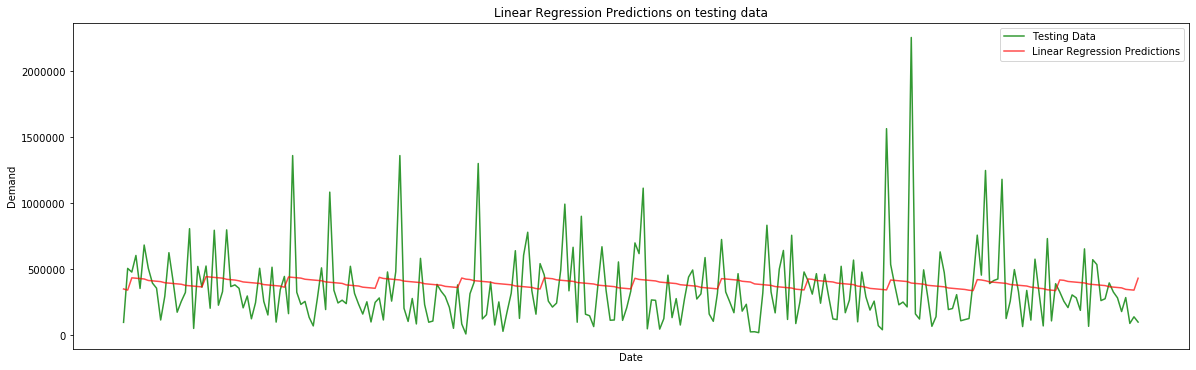

In [289]:
plt.rcParams['figure.figsize'] = [20, 6]
plt.plot(xval.index.values, yval, color='green', label='Testing Data', alpha=0.8)
plt.plot(xval.index.values, reg.predict(xval), color='red', label='Linear Regression Predictions', alpha=0.7)
plt.legend(loc='best')
plt.ylabel("Demand")
plt.xlabel("Date")
plt.title("Linear Regression Predictions on testing data")
plt.xticks([])
plt.show()

- We can do lot better with other models
### Gradient Boosting Model

In [269]:
from xgboost import XGBRegressor

gb =XGBRegressor()
gb= gb.fit(xtr,ytr)
print("Training R2 score",gb.score(xtr,ytr))
print("Testing R2 score",gb.score(xval,yval))

df["xgboost"]=gb.predict(x)

Training R2 score 0.852648878481129
Testing R2 score -0.6673676260758077


- Let's visualize the results of this model

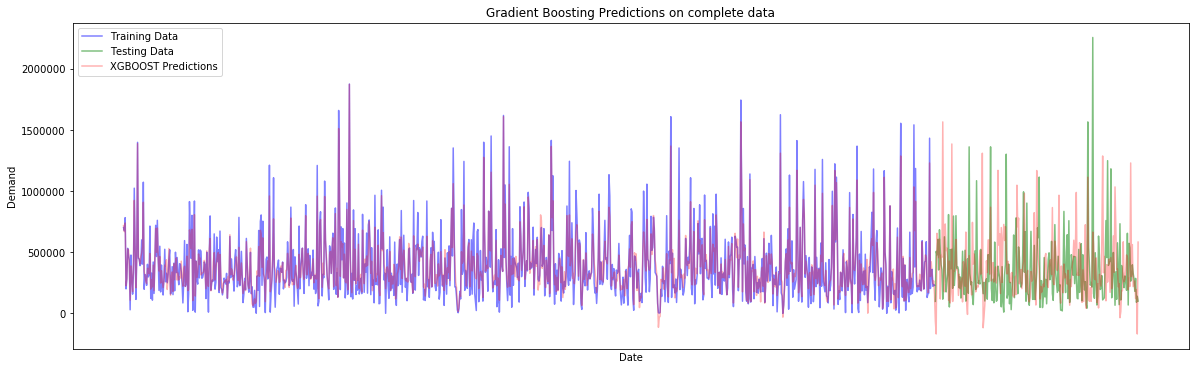

In [285]:
plt.rcParams['figure.figsize'] = [20, 6]
plt.plot(xtr.index.values, ytr, color='blue', label='Training Data', alpha=0.5)
plt.plot(xval.index.values, yval, color='green', label='Testing Data', alpha=0.5)
plt.plot(df.index.values, df['xgboost'], color='red', label='XGBOOST Predictions', alpha=0.3)
plt.legend(loc='best')
plt.ylabel("Demand")
plt.xlabel("Date")
plt.title("Gradient Boosting Predictions on complete data")
plt.xticks([])
plt.show()

- I think this is way more better than previous model
- Lets just look at testing part

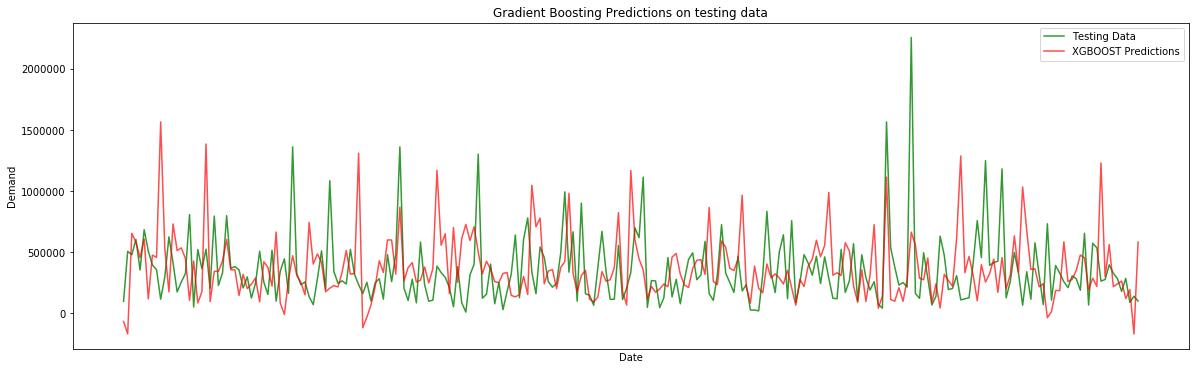

In [287]:
plt.rcParams['figure.figsize'] = [20, 6]
plt.plot(xval.index.values, yval, color='green', label='Testing Data', alpha=0.8)
plt.plot(xval.index.values, gb.predict(xval), color='red', label='XGBOOST Predictions', alpha=0.7)
plt.legend(loc='best')
plt.xticks([])
plt.ylabel("Demand")
plt.xlabel("Date")
plt.title("Gradient Boosting Predictions on testing data")
plt.show()

- We can see that predictions are not consistent but they are pretty good.

## Conclusions and Future Devlopments:
- Linear Regression model performed worst
- Gradient Boosting model was good
- To further improve we can make use of recurrent neural networks(RNN) which I am sure would perform best in such scenarios